In [1]:
import cudf as pd #Change1
import pandas as pdx
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import tensorflow_probability as tfp
import warnings
import time
import gc
import torch
import torch.nn as nn
import lightgbm as lgb
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
print('We will use RAPIDS version',pd.__version__)


from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args
from torch.utils.data import Dataset, DataLoader, TensorDataset
from joblib import dump, load
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error

train_df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
plt.rcParams.update({'font.size': 16})



2023-11-10 22:48:18.138862: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 22:48:18.260535: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 22:48:18.260562: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 22:48:18.261277: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 22:48:18.321700: I tensorflow/core/platform/cpu_feature_g

We will use RAPIDS version 23.10.00


In [2]:
train_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,<NA>,<NA>,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,<NA>,<NA>,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,<NA>,<NA>,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,<NA>,<NA>,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,<NA>,<NA>,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [3]:
import scipy.stats as stats
def stats_df(df_col, col_name, title):
    
    desc_stats = df_col[col_name].describe()

    # IQR
    iqr = desc_stats['75%'] - desc_stats['25%']

    # Kurtosis
    kurt = stats.kurtosis(df_col[col_name])
    
    print("")
    print(title)
    print(desc_stats)
    print(f"IQR: {iqr}")
    print(f"Kurtosis: {kurt}")

In [4]:
stock_0 = train_df.iloc[train_df['stock_id']==0]
stock_0.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,<NA>,<NA>,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,<NA>,<NA>,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,<NA>,<NA>,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,<NA>,<NA>,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,<NA>,<NA>,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0



ref_price
count    26455.000000
mean         0.999835
std          0.001679
min          0.991356
25%          0.998975
50%          0.999827
75%          1.000698
max          1.009097
Name: reference_price, dtype: float64
IQR: 0.001722999999999808
Kurtosis: 2.5737784885295873


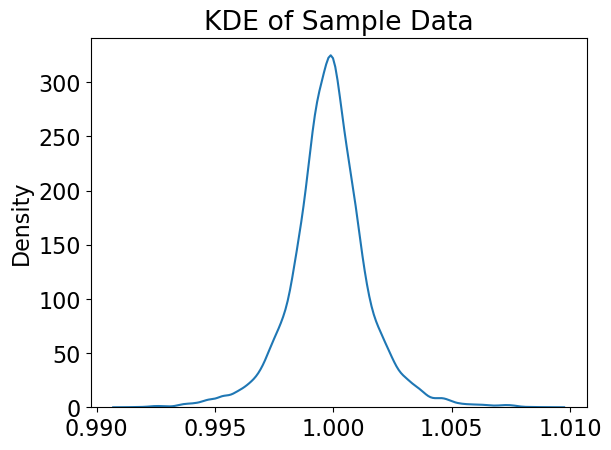

In [8]:
sns.kdeplot(stock_0["reference_price"].values.get())


stats_df(stock_0.to_pandas(), "reference_price", "ref_price")

# Optionally add a title and show the plot
plt.title("KDE of Sample Data")
plt.show()

<Axes: ylabel='Density'>

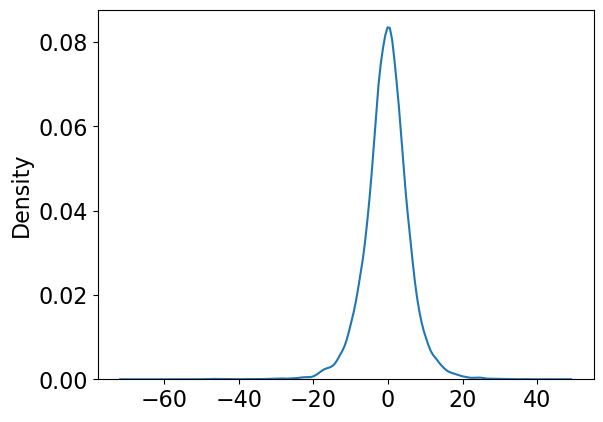

In [6]:
sns.kdeplot(stock_0["target"].values.get())

In [7]:
for i in range(0,10):
    stats_df(train_df.iloc[train_df['stock_id']==i].to_pandas(), "reference_price", f'reference_price_{i}')


reference_price_0
count    26455.000000
mean         0.999835
std          0.001679
min          0.991356
25%          0.998975
50%          0.999827
75%          1.000698
max          1.009097
Name: reference_price, dtype: float64
IQR: 0.001722999999999808
Kurtosis: 2.5737784885295873

reference_price_1
count    26455.000000
mean         0.999926
std          0.002845
min          0.986996
25%          0.998379
50%          0.999900
75%          1.001431
max          1.017256
Name: reference_price, dtype: float64
IQR: 0.0030519999999997216
Kurtosis: 2.6452648359988

reference_price_2
count    26455.000000
mean         1.000149
std          0.002714
min          0.966012
25%          0.998731
50%          1.000118
75%          1.001498
max          1.021975
Name: reference_price, dtype: float64
IQR: 0.002766999999999742
Kurtosis: 11.019234194434231

reference_price_3
count    26455.000000
mean         0.999978
std          0.001451
min          0.993692
25%          0.999201
50%      

In [8]:
import numpy as np
from scipy.stats import kstest, norm, expon
import matplotlib.pyplot as plt

data = stock_0["reference_price"].values.get()

d, p_value = kstest(data, 'norm', args=(np.mean(data), np.std(data)))
print(f"KS Statistic for Normal distribution: {d}")
print(f"P-value for Normal distribution: {p_value}")

from scipy.stats import probplot

# Probability plot for Normal distribution
plt.figure()
probplot(data, dist="norm", plot=plt)
plt.title("Probability Plot for Normal Distribution")

# Probability plot for Exponential distribution
plt.figure()
probplot(data, dist="expon", plot=plt)
plt.title("Probability Plot for Exponential Distribution")

plt.show()

NameError: name 'stock_0' is not defined

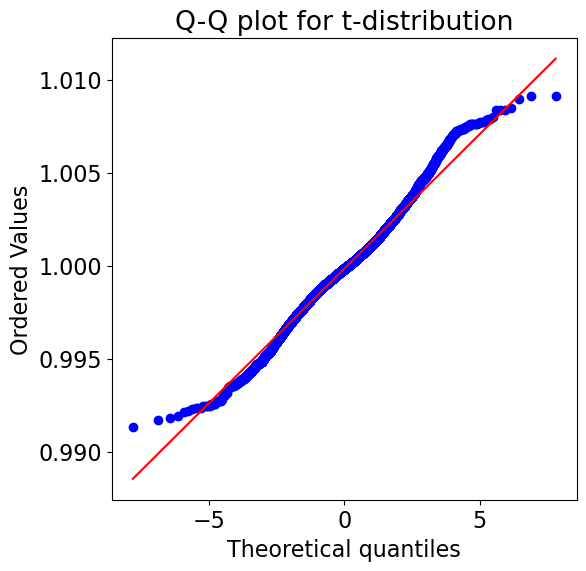

In [15]:
# Q-Q plot
fig, ax = plt.subplots(figsize=(6, 6))
stats.probplot(data, dist="t", sparams=(8,), plot=ax)  # sparams is for df parameter
plt.title("Q-Q plot for t-distribution")
plt.show()

In [16]:
from scipy.stats import kstest, t

# Fit the t-distribution to your data to get parameters
params = t.fit(data)

# Perform the Kolmogorov-Smirnov test
ks_statistic, ks_p_value = kstest(data, 't', args=params)
print("KS Statistic:", ks_statistic)
print("P Value:", ks_p_value)

# Interpretation
alpha = 0.05
if ks_p_value > alpha:
    print(f"Fail to reject the null hypothesis at {alpha*100}% significance level. Data might come from a t-distribution.")
else:
    print(f"Reject the null hypothesis at {alpha*100}% significance level. Data does not come from a t-distribution.")


KS Statistic: 0.00959114708737302
P Value: 0.015290829457468716
Reject the null hypothesis at 5.0% significance level. Data does not come from a t-distribution.


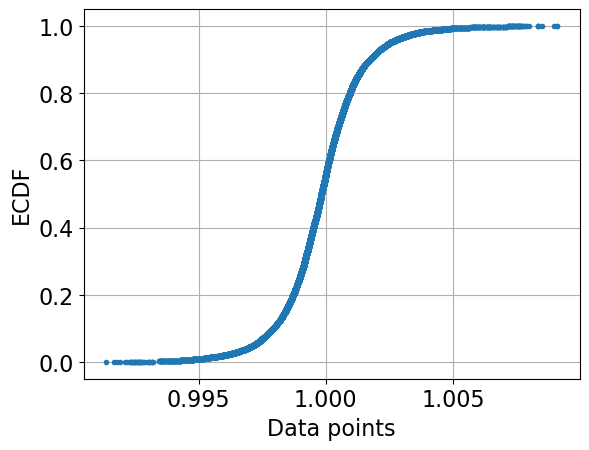

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
data = stock_0["reference_price"].values.get()

# Function to compute ECDF
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    
    # x-data for the ECDF: x
    x = np.sort(data)
    
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    
    return x, y

# Compute ECDF
x, y = ecdf(data)

# Plot ECDF
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Data points')
plt.ylabel('ECDF')
plt.grid(True)
plt.show()

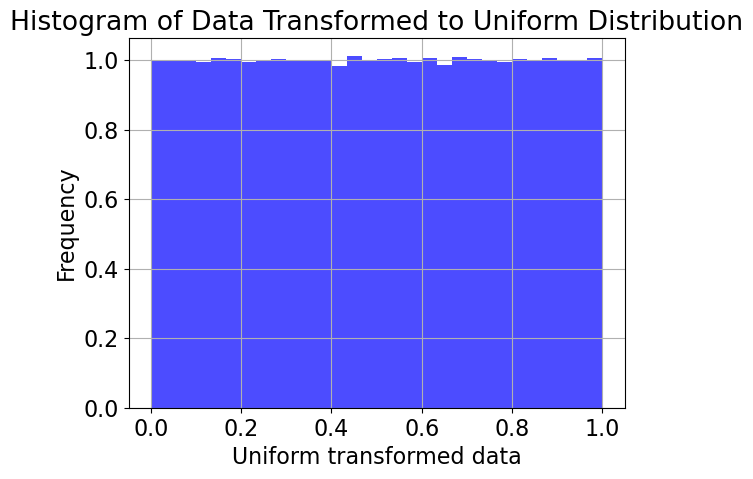

In [11]:
uniform_data = np.interp(data, x, y)

# Plot transformed data to check uniform distribution
plt.hist(uniform_data, bins=30, density=True, alpha=0.7, color='blue')
plt.xlabel('Uniform transformed data')
plt.ylabel('Frequency')
plt.title('Histogram of Data Transformed to Uniform Distribution')
plt.grid(True)
plt.show()

In [13]:
np.interp([1.0], x, y)

array([0.56012096])

In [ ]:
cat_cols = ['stock_id', 'imbalance_buy_sell_flag','seconds_in_bucket']
num_cols = ['']

* Compute ECDF for each stock and then transform using interp
